<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/Figures_4_5_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ase
!pip install asap3

     |████████████████████████████████| 2.1MB 2.5MB/s 
     |████████████████████████████████| 808kB 2.7MB/s 
  Created wheel for asap3: filename=asap3-3.11.10-cp36-cp36m-linux_x86_64.whl size=6804551 sha256=90b3f6b2efbac654e9f3a5875576e08f80a53c0acc1e8a0d64a9b6d2c92e115f
  Stored in directory: /root/.cache/pip/wheels/7f/61/45/13d16abf6fd0a96e46e8d479e0333b6f4ab4d14e548682f359
Successfully built asap3


In [ ]:
import ase.io
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from asap3.analysis.rdf import RadialDistributionFunction
import random
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
file_dir = "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/md runs/dft/"

In [ ]:
def get_energies(traj):
  ml_energies = np.array([image.get_potential_energy(apply_constraint=False) for image in traj])
  return ml_energies

def get_forces(traj):
  ml_forces = np.concatenate(np.array([image.get_forces(apply_constraint=False) for image in traj]))
  return ml_forces

def get_rdf(images, rMax=5, nBins=200):
  RDFobj = None
  for atoms in images:
    if RDFobj is None:
      RDFobj = RadialDistributionFunction(atoms, rMax, nBins)
    else:
      RDFobj.atoms = atoms
    RDFobj.update()
  rdf = RDFobj.get_rdf()
  x = np.arange(nBins) * rMax/nBins
  return x, rdf

def time_plot(images):
  energies = get_energies(images)
  forces = get_forces(images)
  plt.plot(range(len(energies)), energies)

def parity_plots(x, y, saveas, mae, energy=True):
    lims = [np.min(x)-0.2, np.max(x)+0.2]
    grid = sns.jointplot(x, y, kind='hex', bins='log', height=8)
    ax = grid.ax_joint
    ax.plot(lims, lims, '--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.tick_params(axis="both", labelsize=23)
    if energy:
      text = f"MAE: {mae:.5f} eV"
      ax.set_xlabel("DFT energy, eV", fontsize=27)
      ax.set_ylabel("Energy pred., eV", fontsize=27)
      _ = ax.text(x=lims[0], y=lims[1], s=text,
              horizontalalignment='left',
              verticalalignment='top',
              fontsize=27)
    else:
      text = f"MAE: {mae:.5f} eV/$\AA$"
      ax.set_xlabel("DFT forces, eV/$\AA$", fontsize=27)
      ax.set_ylabel("Force pred., eV/$\AA$", fontsize=27)
      _ = ax.text(x=lims[0]+0.05, y=lims[1], s=text,
              horizontalalignment='left',
              verticalalignment='top',
              fontsize=27)
    plt.tight_layout()
    plt.savefig(saveas, dpi=300)

In [ ]:
parent_traj = ase.io.read(os.path.join(file_dir, "dft_md/dft_md_2k.traj"), ":2001")
parent_energies = [image.get_potential_energy(apply_constraint=False) for image in parent_traj]

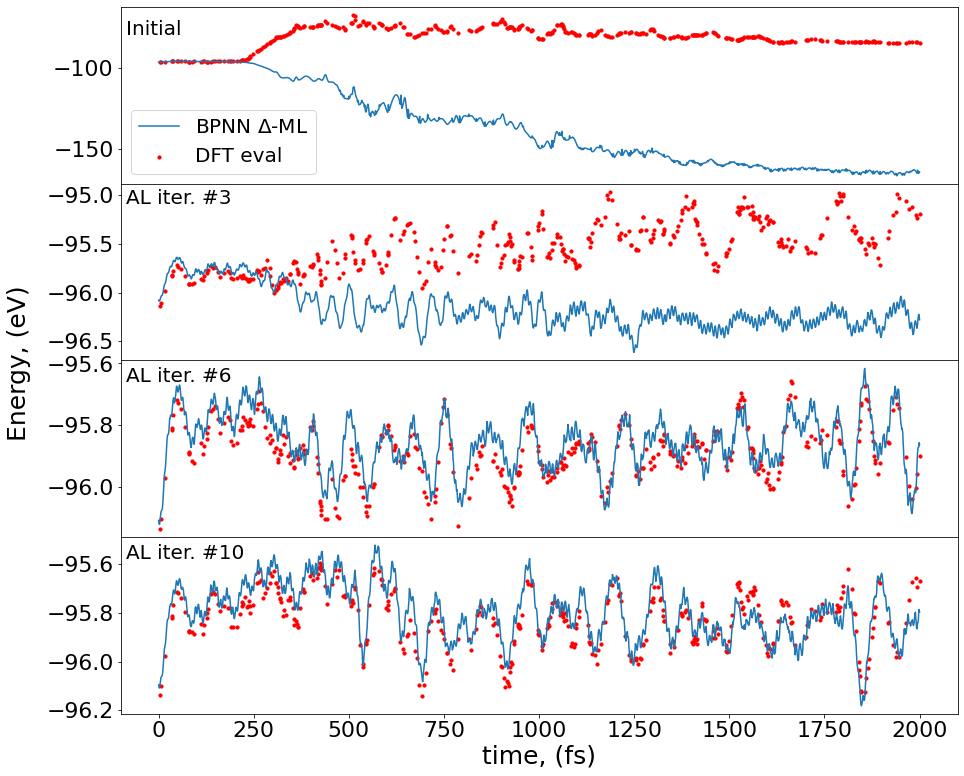

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 13))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
time = range(2001)

random.seed(4532)
points = random.sample(range(len(parent_traj)), 400)

iters = [1, 3, 6, 10]

# Plot each graph, and manually set the y tick values
for idx, i in enumerate(iters):
  ml_images = ase.io.read(file_dir+f"al_md_dft/al_md_dft_ex_iter_{i}.traj", ":")
  eval_points = ase.io.read(file_dir+f"al_md_dft/test_{i}/al_md_dft_check_iter_{i}.traj", ":")
  eval_energies = get_energies(eval_points)

  axs[idx].plot(time, get_energies(ml_images), label="BPNN $\Delta$-ML")
  axs[idx].scatter(points, eval_energies, color='r', s=10, label="DFT eval")
  if idx == 0:
    axs[idx].legend(loc="lower left", fontsize=20 )
  axs[idx].tick_params(axis="y", labelsize=22)
  if idx == 3: 
    axs[idx].set_xlabel("time, (fs)", fontsize=25)
    axs[idx].tick_params(axis="x", labelsize=22) 

fig.text(0.02, 0.5, 'Energy, (eV)', va='center', rotation='vertical', fontsize=25)
fig.text(0.13, 0.85, 'Initial', fontsize=20, color="k")
fig.text(0.13, 0.67, f'AL iter. #{iters[1]}', fontsize=20, color="k")
fig.text(0.13, 0.48, f'AL iter. #{iters[2]}', fontsize=20, color="k")
fig.text(0.13, 0.29, f'AL iter. #{iters[3]}', fontsize=20, color="k")
fig.savefig("al_iter_md.png", dpi=300)

In [ ]:
all_mae_e = []
all_mae_f = []
for i in range(11):
  ml_images = ase.io.read(file_dir+f"al_md_dft/al_md_dft_ex_iter_{i}.traj", ":")
  ml_sample = [ml_images[idx] for idx in points]
  ml_sample_energies = get_energies(ml_sample)
  ml_sample_forces = get_forces(ml_sample)

  test_points = ase.io.read(file_dir+f"al_md_dft/test_{i}/al_md_dft_check_iter_{i}.traj", ":")
  test_energies = get_energies(test_points)
  test_forces = get_forces(test_points)

  energy_mae = np.mean(np.abs(ml_sample_energies - test_energies))
  forces_mae = np.mean(np.abs(ml_sample_forces - test_forces))
  all_mae_e.append(energy_mae)
  all_mae_f.append(forces_mae)

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:921: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


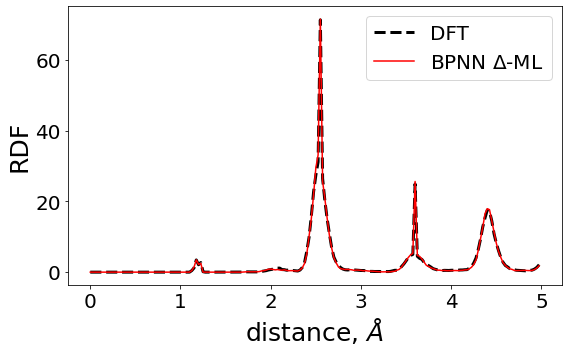

In [ ]:
ml_images = ase.io.read(file_dir+f"al_md_dft/al_md_dft_ex_iter_6.traj", ":")

plt.figure(figsize=(8,5))
x_dft, rdf_dft = get_rdf(parent_traj, rMax=5, nBins=200)
x_ml, rdf_ml = get_rdf(ml_images, rMax=5, nBins=200)
plt.plot(x_dft, rdf_dft, "--k", lw=3, label="DFT")
plt.plot(x_ml, rdf_ml, "-r", label="BPNN $\Delta$-ML")
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.xlabel("distance, $\AA$", fontsize=25)
plt.ylabel("RDF", fontsize=25)
plt.tight_layout()
plt.savefig("al_rdf_comp.png", dpi=300)

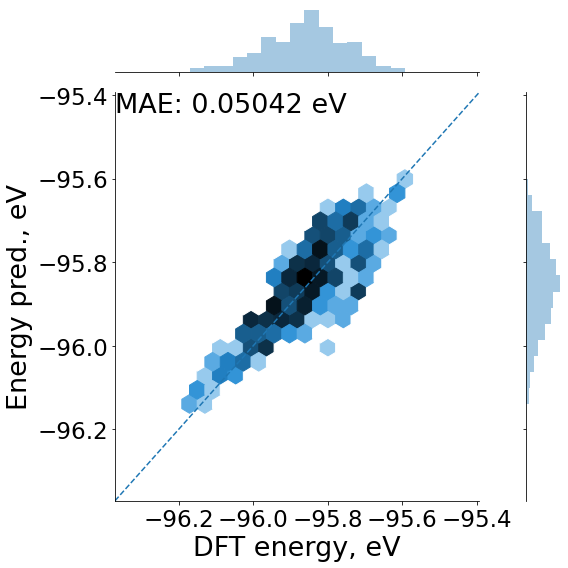

In [ ]:
i = 9

ml_images = ase.io.read(file_dir+f"al_md_dft/al_md_dft_ex_iter_{i}.traj", ":")
ml_sample = [ml_images[idx] for idx in points]
ml_sample_energies = get_energies(ml_sample)
ml_sample_forces = get_forces(ml_sample)

test_points = ase.io.read(file_dir+f"al_md_dft/test_{i}/al_md_dft_check_iter_{i}.traj", ":")
test_energies = get_energies(test_points)
test_forces = get_forces(test_points)

energy_mae = np.mean(np.abs(ml_sample_energies - test_energies))
forces_mae = np.mean(np.abs(ml_sample_forces - test_forces))

parity_plots(test_energies, ml_sample_energies, saveas="md_parity_energy.png", mae=energy_mae)

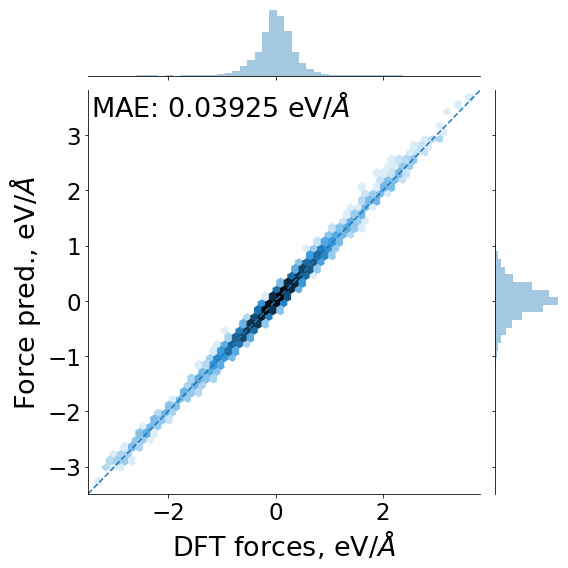

In [ ]:
parity_plots(test_forces, ml_sample_forces, saveas="md_parity_forces.png", mae=forces_mae, energy=False)